**HyperTS supports univariate and multivariate time series anomaly detection tasks.**

**In this NoteBook, we will use HyperTS to do a time series anomaly detection task.**

###  Step 1: Let`s still use **realKnownCause** dataset, import it and do EDA.

In [1]:
from hyperts.datasets import load_real_known_cause_dataset

Load Data:

In [2]:
df = load_real_known_cause_dataset()

In [3]:
df.head()

,timestamp,value,anomaly
0,2013-12-02 21:15:00,73.967322,0
1,2013-12-02 21:20:00,74.935882,0
2,2013-12-02 21:25:00,76.124162,0
3,2013-12-02 21:30:00,78.140707,0
4,2013-12-02 21:35:00,79.329836,0


From the table, we can see that:

- timestamp column name: 'timestamp';
- feature column name: 'value';
- label column name: 'anomaly';
- time freq: '5T';

The anomaly detection scenario is usually unlabeled, so we remove the label column and transform it into an unsuperised task.

In [4]:
ground_truth = df.pop('anomaly')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22683 entries, 0 to 22682
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  22683 non-null  object 
 1   value      22683 non-null  float64
dtypes: float64(1), object(1)
memory usage: 354.5+ KB


Split train_data and test_data

In [6]:
from hyperts.toolbox import temporal_train_test_split

In [7]:
train_data, test_data = temporal_train_test_split(df, test_horizon=15000)

Visulization of train_data curve and test_data curve.

In [8]:
outliers = ground_truth.loc[ground_truth.values == 1]
outliers_index = list(outliers.index)

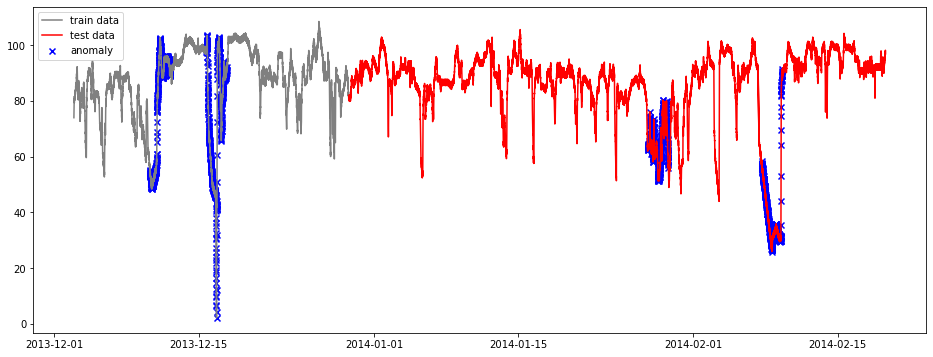

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 6))
plt.plot(pd.to_datetime(train_data['timestamp']), 
         train_data['value'], 
         c='gray', 
         label='train data')
plt.plot(pd.to_datetime(test_data['timestamp']), 
         test_data['value'], 
         c='red', 
         label='test data')
plt.scatter(pd.to_datetime(df.loc[outliers_index, 'timestamp']), 
            df.loc[outliers_index, 'value'], 
            c='blue',
            marker='x',
            label='anomaly')
plt.legend()
plt.show()

###  Step 2: Create experiments and search for models.

Configure some parameters for experiment. For details, see make_experiment comments.

In [10]:
from hyperts import make_experiment

In [11]:
experiment = make_experiment(
    train_data=train_data.copy(),
    mode='stats',
    task='detection',
    timestamp='timestamp',
    max_trials=30,
    random_state=2022)

model = experiment.run()

### Step 3: Gets pipeline model parameters.

In [12]:
model.get_pipeline_params()

<bound method Pipeline.get_params of Pipeline(steps=[('data_preprocessing',
                 TSFDataPreprocessStep(covariate_cleaner=IdentityTransformer(),
                                       ensemble_size=10, freq='5T',
                                       name='data_preprocessing',
                                       timestamp_col=['timestamp'])),
                ('estimator',
                 TSGreedyEnsemble(weight=[0.4, 0.0, 0.6, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], scores=[0.7789473684210527, 0.7789473684210527, 0.7789473684210527, 0.7789473684210527, 0.7789473684210527, 0.7789473684210527, 0.7789473684210527, 0.7789473684210527, 0.7789473684210527, 0.7789473684210527]))])>

### Step 4: Detection on test data (unknown data).

In [13]:
X_test, _ = model.split_X_y(test_data.copy())

In [14]:
X_test.head()

,timestamp,value
0,2013-12-29 13:30:00,82.032343
1,2013-12-29 13:35:00,80.900366
2,2013-12-29 13:40:00,81.031536
3,2013-12-29 13:45:00,80.200337
4,2013-12-29 13:50:00,80.182448


In [15]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

In [16]:
y_pred.head()

,timestamp,anomaly,severity
0,2013-12-29 13:30:00,0,0.138589
1,2013-12-29 13:35:00,0,0.178984
2,2013-12-29 13:40:00,0,0.162511
3,2013-12-29 13:45:00,0,0.203910
4,2013-12-29 13:50:00,0,0.202604


The `predict` of HyperTS'model will output a DataFrame containing the **anomaly** and **severity** for each timestamp.

In [17]:
y_test = ground_truth.iloc[-15000:]

In [18]:
scores = model.evaluate(y_true=y_test, y_pred=y_pred, y_proba=y_proba)

In [19]:
scores

,Metirc,Score
0,accuracy,0.9480
1,f1,0.5933
2,precision,0.7258
3,recall,0.5018


### Step6: Visualize the detection curve.

HyperTS supports two ways to draw forecast curves: interactive (plotly installation required) and non-interactive (matplotlib installation required). The default is interactive. If you want to draw non-interactive, you can set ```interactive=False```.

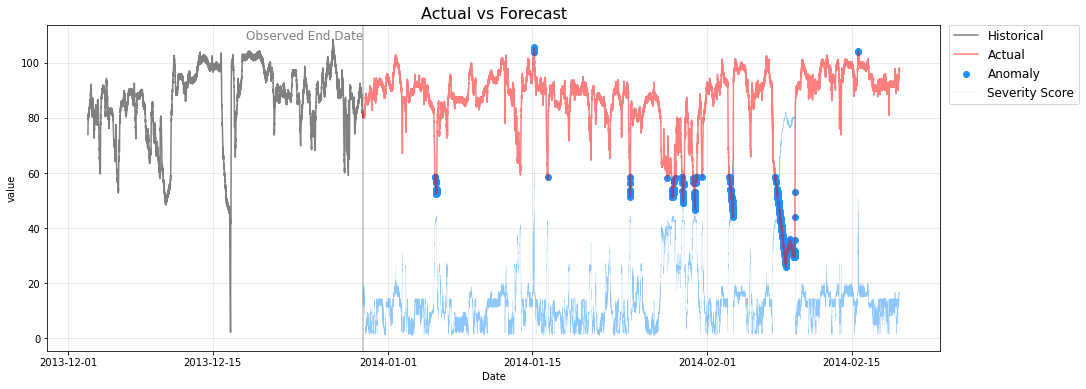

In [20]:
model.plot(y_pred, actual=test_data, history=train_data, interactive=False)